# rent回归模型

In [1]:
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_rent = pd.read_csv('ruc_Class25Q2_train_rent.csv', low_memory=False)    # 租赁训练集 low_memory=False可以一次读取整个文件而不是分块读取
test_rent = pd.read_csv('ruc_Class25Q2_test_rent.csv', low_memory=False)      # 租赁测试集

# 查看数据基本信息
print("原始train_rent形状：", train_rent.shape)
print("原始test_rent形状：", test_rent.shape)
print("\ntrain_rent前3行：")
display(train_rent.head(3)) # 格式化表格显示

原始train_rent形状： (98899, 46)
原始test_rent形状： (9773, 46)

train_rent前3行：


,城市,户型,装修,Price,楼层,面积,朝向,交易时间,付款方式,租赁方式,...,供水,供暖,供电,燃气费,供热费,停车位,停车费用,coord_x,coord_y,客户反馈
0,0,1室1厅1卫,精装修,654646.481811,4/6层,36.42㎡,西,2024-11-28,季付价,整租,...,民水,集中供暖,民电,2.61元/m³,24-30元/㎡,450.0,150,117.339283,40.930007,潮气重，仔细一看，房屋保养好
1,0,1室1厅1卫,精装修,665412.057415,4/6层,41.00㎡,南,2024-10-30,季付价,整租,...,民水,集中供暖,民电,2.61元/m³,30元/㎡,150.0,150,117.446526,40.876743,服务响应中等，看起来，管线老化，消防设施齐全
2,0,1室1厅1卫,精装修,778222.820548,1/18层,37.36㎡,北,2024-11-12,季付价,整租,...,商水/民水,集中供暖,商电/民电,2.61-2.63元/m³,30-46元/㎡,965.0,500,117.518524,40.905357,差不多这样，电梯新，总的来说，宽敞，性价比高


## step1 数据处理

In [3]:
rent_stats = {
    # 文本特征关键词（后续用于情感/关键词得分）
    'positive_words': ['方便', '和谐', '齐全', '干净', '优美', '顺畅', '充足', '方正', '高效',
                      '丰富', '先进', '稳定', '宽敞', '清晰', '佳', '舒适', '新颖', '合理',
                      '稳固', '清爽', '出色', '紧实', '结实', '精致', '优秀', '成熟', '快捷',
                      '便捷', '便利', '安全', '整洁'],
    'negative_words': ['堪忧', '蚊虫', '损坏', '嘈杂', '堵塞', '老旧', '差', '困难', '一般',
                      '老化', '不足', '发霉', '噪声', '刺鼻', '故障', '拖延', '混乱', '推诿',
                      '漏水', '潮湿', '脱落', '松动', '杂乱', '频繁', '剥落', '乱', '噪音',
                      '不稳', '坏', '异味'],
    'facility_keywords': ['冰箱', '床', '暖气', '宽带', '天然气', '洗衣机', '空调', '热水器', '衣柜', '电视']
}

In [4]:
"""删除训练集中缺失值过多的行（缺失25个及以上特征的行）"""
print("删除高缺失值行之前训练集形状:", train_rent.shape)

# 计算每行的缺失值数量
row_missing_counts = train_rent.isnull().sum(axis=1) # insnull检测每个元素是否为缺失值 axis=1是按行求和

# 找出缺失25个及以上特征的行
high_missing_rows = row_missing_counts[row_missing_counts >= 25]
print(f"缺失25个及以上特征的行数: {len(high_missing_rows)}")

if len(high_missing_rows) > 0:
    # 删除这些行
    train_rent = train_rent.drop(high_missing_rows.index)
    
    print(f"删除高缺失值行之后训练集形状: {train_rent.shape}")
    print(f"共删除了 {len(high_missing_rows)} 行数据")
else:
    print("没有发现缺失25个及以上特征的行")

删除高缺失值行之前训练集形状: (98899, 46)
缺失25个及以上特征的行数: 5988
删除高缺失值行之后训练集形状: (92911, 46)
共删除了 5988 行数据


In [5]:
"""删除没有用或者信息质量很差的列"""
drop_cols = ['租期', '环线位置', '物业办公电话'] 
train_rent = train_rent.drop(columns=drop_cols, errors='ignore')  # errors='ignore':如果列不存在不会报错，增加代码稳健性
test_rent = test_rent.drop(columns=drop_cols, errors='ignore')
print(f"删除无关列后，train_rent形状：{train_rent.shape}，test_rent形状：{test_rent.shape}")

删除无关列后，train_rent形状：(92911, 43)，test_rent形状：(9773, 43)


In [6]:
"""数值转换（针对本来就含有数值的数据列，处理区间值、单位等）"""
def convert_to_numeric(s):
    if pd.isna(s): # 检查输入值是否为缺失值，缺失值直接返回None
        return None
    s = str(s).strip() #强制转换为字符串
    # 移除常见单位（保留数值和区间符号）
    s = re.sub(r'[元/月m³㎡户年%个]', '', s)
    s = s.replace('~', '-')  # 统一区间符号为"-"
    # 处理区间值（如"2-3"取平均）
    if '-' in s:
        parts = s.split('-')
        if len(parts) == 2:
            try:
                return (float(parts[0].strip()) + float(parts[1].strip())) / 2
            except:
                pass  # 转换失败则提取单个数值
    # 提取单个数值（支持整数和小数）
    nums = re.findall(r'(\d+\.?\d*)', s) # \d+: 1个或多个数字 \.?: 可选的小数点 \d*: 0个或多个数字（小数点后的数字）
    return float(nums[0]) if nums else None

# 对数值列执行转换（如面积、建筑年代等）
numeric_cols = [
    '面积', '建筑年代', '房屋总数', '楼栋总数', '绿 化 率', 
    '物 业 费', '容 积 率', '燃气费', '供热费', '停车位', '停车费用',
    'coord_x','coord_y'
]
for col in numeric_cols:
    if col in train_rent.columns:
        train_rent[col] = train_rent[col].apply(convert_to_numeric)
        print(f"已转换'{col}'，训练集缺失值：{train_rent[col].isna().sum()}")
    if col in test_rent.columns:
        test_rent[col] = test_rent[col].apply(convert_to_numeric)


# 将交易时间转为datetime类型
if '交易时间' in train_rent.columns:
    train_rent['交易时间'] = pd.to_datetime(train_rent['交易时间'], errors='coerce')# 转换失败的值变为NaT（Not a Time）
    test_rent['交易时间'] = pd.to_datetime(test_rent['交易时间'], errors='coerce')

已转换'面积'，训练集缺失值：0
已转换'建筑年代'，训练集缺失值：20161
已转换'房屋总数'，训练集缺失值：35
已转换'楼栋总数'，训练集缺失值：35
已转换'绿 化 率'，训练集缺失值：18414
已转换'物 业 费'，训练集缺失值：16171
已转换'容 积 率'，训练集缺失值：18092
已转换'燃气费'，训练集缺失值：19069
已转换'供热费'，训练集缺失值：64076
已转换'停车位'，训练集缺失值：19491
已转换'停车费用'，训练集缺失值：22458
已转换'coord_x'，训练集缺失值：35
已转换'coord_y'，训练集缺失值：35


In [7]:
"""缺失值填充"""
# 1. 分类列缺失值：分别处理（自定义填充值 + 众数填充）
cat_cols = ['户型', '楼层', '朝向', '物业类别', '建筑结构', '产权描述', 
            '供水', '供暖', '供电', '付款方式', '电梯', '用水', '用电', 
            '燃气', '车位', '采暖', '配套设施']

# 定义特殊列的填充值（新增“供水”“供电”用“未知”填充）
special_fill_values = {
    '车位': '无车位',
    '采暖': '无采暖', 
    '配套设施': '无配套设施',
    '供暖': '无供暖',
    '供水': '未知', 
    '供电': '未知'  
}

for col in cat_cols:
    if col in train_rent.columns:
        # 判断是否使用特殊填充值
        if col in special_fill_values:
            fill_value = special_fill_values[col]
            # 保存特殊填充值到rent_stats
            rent_stats[f'{col}_fill_value'] = fill_value
            # 填充训练集
            train_rent[col] = train_rent[col].fillna(fill_value)
            # 用相同值填充测试集（保持一致）
            if col in test_rent.columns:
                test_rent[col] = test_rent[col].fillna(fill_value)
            print(f"{col}：用自定义值'{fill_value}'填充缺失值")
        else:
            # 其他列仍使用众数填充
            mode_val = train_rent[col].mode()[0]
            rent_stats[f'{col}_mode'] = mode_val
            # 填充训练集
            train_rent[col] = train_rent[col].fillna(mode_val)
            # 用训练集众数填充测试集（避免数据泄露）
            if col in test_rent.columns:
                test_rent[col] = test_rent[col].fillna(mode_val)
            print(f"{col}：用众数'{mode_val}'填充缺失值")

# 2. 数值列：用训练集中位数或者0填充
# 定义特殊数值列的填充值（用0填充）
special_numeric_fill_values = {
    '供热费': 0,
    '停车位': 0, 
    '停车费用': 0
}
for col in numeric_cols:
    if col in train_rent.columns:
        # 判断是否使用特殊填充值
        if col in special_numeric_fill_values:
            fill_value = special_numeric_fill_values[col]
            # 保存特殊填充值到rent_stats
            rent_stats[f'{col}_fill_value'] = fill_value
            # 填充训练集
            train_rent[col] = train_rent[col].fillna(fill_value)
            # 用相同值填充测试集
            if col in test_rent.columns:
                test_rent[col] = test_rent[col].fillna(fill_value)
            print(f"{col}：用自定义值'{fill_value}'填充缺失值")
        else:
            # 使用中位数填充
            median_val = train_rent[col].median()
            rent_stats[f'{col}_median'] = median_val
            # 填充训练集
            train_rent[col] = train_rent[col].fillna(median_val)
            # 用训练集中位数填充测试集
            if col in test_rent.columns:
                test_rent[col] = test_rent[col].fillna(median_val)
            print(f"{col}：用中位数'{median_val:.2f}'填充缺失值")

# 3. 特殊列填充
# 区县和板块用随机值填充
location_cols = ['区县', '板块']
for col in location_cols:
    if col in train_rent.columns:
        # 训练集：提取非缺失值的唯一值列表
        non_na_vals = train_rent[col].dropna().unique()
        # 随机填充训练集缺失值
        train_rent[col] = train_rent[col].apply(
            lambda x: np.random.choice(non_na_vals) if pd.isna(x) else x
        )
        rent_stats[f'{col}_non_na_vals'] = non_na_vals  # 保存非缺失值列表供测试集使用
        print(f"{col}（训练集）：随机填充{train_rent[col].isna().sum()}个缺失值")
        
        # 测试集：复用训练集的非缺失值列表进行随机填充
        if col in test_rent.columns:
            test_rent[col] = test_rent[col].apply(
                lambda x: np.random.choice(non_na_vals) if pd.isna(x) else x
            )
            print(f"{col}（测试集）：随机填充{test_rent[col].isna().sum()}个缺失值")

# 装修：缺失值填充为"未装修"，编码0和1
if '装修' in train_rent.columns:
    train_rent['装修'] = train_rent['装修'].fillna('未装修')
    test_rent['装修'] = test_rent['装修'].fillna('未装修')
    rent_stats['装修_map'] = {'未装修': 0, '精装修': 1}  # 编码映射规则
    print("装修：缺失值填充为'未装修'")


# 开发商、物业公司：缺失值赋值0，其余赋值1
company_cols = ['开发商', '物业公司']
for col in company_cols:
    if col in train_rent.columns:
        # 训练集：缺失值填0，非缺失值填1
        train_rent[col] = train_rent[col].notna().astype(int) # train_rent[col].notna(): 检测非缺失值，返回True/False .astype(int): 转换为整数，True→1，False→0
        # 测试集：同样处理
        if col in test_rent.columns:
            test_rent[col] = test_rent[col].notna().astype(int)
        print(f"{col}：已转换为数值类型（缺失=0，存在=1）")

# 验证填充结果
print("\n填充后训练集缺失值数量：")
print(train_rent.isna().sum()[train_rent.isna().sum() > 0])  

户型：用众数'2室1厅'填充缺失值
楼层：用众数'高楼层/6层'填充缺失值
朝向：用众数'南'填充缺失值
物业类别：用众数'普通住宅'填充缺失值
建筑结构：用众数'塔楼'填充缺失值
产权描述：用众数'商品房'填充缺失值
供水：用自定义值'未知'填充缺失值
供暖：用自定义值'无供暖'填充缺失值
供电：用自定义值'未知'填充缺失值
付款方式：用众数'季付价'填充缺失值
电梯：用众数'有'填充缺失值
用水：用众数'民水'填充缺失值
用电：用众数'民电'填充缺失值
燃气：用众数'有'填充缺失值
车位：用自定义值'无车位'填充缺失值
采暖：用自定义值'无采暖'填充缺失值
配套设施：用自定义值'无配套设施'填充缺失值
面积：用中位数'77.42'填充缺失值
建筑年代：用中位数'2008.00'填充缺失值
房屋总数：用中位数'1445.00'填充缺失值
楼栋总数：用中位数'13.00'填充缺失值
绿 化 率：用中位数'35.00'填充缺失值
物 业 费：用中位数'2.20'填充缺失值
容 积 率：用中位数'2.67'填充缺失值
燃气费：用中位数'2.95'填充缺失值
供热费：用自定义值'0'填充缺失值
停车位：用自定义值'0'填充缺失值
停车费用：用自定义值'0'填充缺失值
coord_x：用中位数'117.26'填充缺失值
coord_y：用中位数'32.15'填充缺失值
区县（训练集）：随机填充0个缺失值
区县（测试集）：随机填充0个缺失值
板块（训练集）：随机填充0个缺失值
板块（测试集）：随机填充0个缺失值
装修：缺失值填充为'未装修'
开发商：已转换为数值类型（缺失=0，存在=1）
物业公司：已转换为数值类型（缺失=0，存在=1）

填充后训练集缺失值数量：
Series([], dtype: int64)


In [8]:
"""转换数据类型（针对分类特征，转换为数值类型）"""
# 1. 户型：提取数字求和（如"3室2厅"→5）
def extract_house_type(s):
    nums = re.findall(r'\d+', str(s))
    return sum(int(num) for num in nums) if nums else 0

if '户型' in train_rent.columns:
    train_rent['户型_数值和'] = train_rent['户型'].apply(extract_house_type)
    test_rent['户型_数值和'] = test_rent['户型'].apply(extract_house_type)
    # 删除原始列
    train_rent = train_rent.drop(columns=['户型'])
    test_rent = test_rent.drop(columns=['户型'])
print("户型：转换为数值和，删除原始列")

# 2. 装修：0/1编码（基于rent_stats中的映射规则）
if '装修' in train_rent.columns:
    train_rent['装修_编码'] = train_rent['装修'].map(rent_stats['装修_map']).fillna(0)
    test_rent['装修_编码'] = test_rent['装修'].map(rent_stats['装修_map']).fillna(0)
    train_rent = train_rent.drop(columns=['装修'])
    test_rent = test_rent.drop(columns=['装修'])
print("装修：转换为0/1编码，删除原始列")

# 3. 楼层：分类后热编码
def process_floor(s):
    s = str(s).lower()
    if '地' in s: return '地'
    elif '低' in s: return '低'
    elif '中' in s: return '中'
    elif '高' in s: return '高'
    elif '/' in s:
        parts = s.split('/')
        if len(parts) == 2:
            try:
                ratio = float(parts[0].strip()) / float(parts[1].strip())
                return '低' if ratio <= 0.3 else '中' if ratio < 0.7 else '高'
            except:
                return '其他'
    return '其他'

if '楼层' in train_rent.columns:
    # 训练集处理
    train_rent['楼层_分类'] = train_rent['楼层'].apply(process_floor)
    train_rent = pd.get_dummies(train_rent, columns=['楼层_分类'], prefix='楼层', drop_first=True)
    # 测试集处理（对齐训练集列）
    test_rent['楼层_分类'] = test_rent['楼层'].apply(process_floor)
    test_rent = pd.get_dummies(test_rent, columns=['楼层_分类'], prefix='楼层', drop_first=True)
    # 保存热编码列名到rent_stats
    floor_cols = [col for col in train_rent.columns if col.startswith('楼层_')]
    rent_stats['floor_cols'] = floor_cols
    # 补充测试集缺失的列（填0）
    for col in floor_cols:
        if col not in test_rent.columns:
            test_rent[col] = 0
    # 删除原始列
    train_rent = train_rent.drop(columns=['楼层'])
    test_rent = test_rent.drop(columns=['楼层'])
print("楼层：热编码处理，删除原始列")

# 4. 朝向：是否朝南（1=是，0=否）
if '朝向' in train_rent.columns:
    train_rent['朝向_朝南'] = train_rent['朝向'].apply(lambda x: 1 if '南' in str(x) else 0)
    test_rent['朝向_朝南'] = test_rent['朝向'].apply(lambda x: 1 if '南' in str(x) else 0)
    train_rent = train_rent.drop(columns=['朝向'])
    test_rent = test_rent.drop(columns=['朝向'])
print("朝向：转换为是否朝南，删除原始列")

# 5. 交易时间：提取年份和季度
if '交易时间' in train_rent.columns:
    train_rent['交易年份'] = train_rent['交易时间'].dt.year
    train_rent['交易季度'] = train_rent['交易时间'].dt.quarter
    test_rent['交易年份'] = test_rent['交易时间'].dt.year
    test_rent['交易季度'] = test_rent['交易时间'].dt.quarter
    # 保存年份/季度中位数（用于测试集填充）
    rent_stats['交易年份_median'] = train_rent['交易年份'].median()
    rent_stats['交易季度_median'] = train_rent['交易季度'].median()
    test_rent['交易年份'] = test_rent['交易年份'].fillna(rent_stats['交易年份_median'])
    test_rent['交易季度'] = test_rent['交易季度'].fillna(rent_stats['交易季度_median'])
    # 删除原始列
    train_rent = train_rent.drop(columns=['交易时间'])
    test_rent = test_rent.drop(columns=['交易时间'])
print("交易时间：提取年份和季度，删除原始列")

# 6. 物业类别：是否含别墅（1=是，0=否）
if '物业类别' in train_rent.columns:
    train_rent['物业类别_含别墅'] = train_rent['物业类别'].apply(lambda x: 1 if '别墅' in str(x) else 0)
    test_rent['物业类别_含别墅'] = test_rent['物业类别'].apply(lambda x: 1 if '别墅' in str(x) else 0)
    train_rent = train_rent.drop(columns=['物业类别'])
    test_rent = test_rent.drop(columns=['物业类别'])
print("物业类别：转换为是否含别墅，删除原始列")

# 7. 建筑结构：分级编码（3=平房，2=板楼，1=塔板结合，0=其他）
def process_structure(s):
    s = str(s).lower()
    if '平房' in s: return 3
    elif '板楼' in s: return 2
    elif '塔板结合' in s: return 1
    else: return 0

if '建筑结构' in train_rent.columns:
    train_rent['建筑结构_分级'] = train_rent['建筑结构'].apply(process_structure)
    test_rent['建筑结构_分级'] = test_rent['建筑结构'].apply(process_structure)
    train_rent = train_rent.drop(columns=['建筑结构'])
    test_rent = test_rent.drop(columns=['建筑结构'])
print("建筑结构：转换为分级编码，删除原始列")

# 8. 产权描述：是否含商品房（1=是，0=否）
if '产权描述' in train_rent.columns:
    train_rent['产权描述_含商品房'] = train_rent['产权描述'].apply(lambda x: 1 if '商品房' in str(x) else 0)
    test_rent['产权描述_含商品房'] = test_rent['产权描述'].apply(lambda x: 1 if '商品房' in str(x) else 0)
    train_rent = train_rent.drop(columns=['产权描述'])
    test_rent = test_rent.drop(columns=['产权描述'])
print("产权描述：转换为是否含商品房，删除原始列")

# 9. 供水/供暖/供电：热编码
for col in ['供水', '供暖', '供电']:
    if col in train_rent.columns:
        # 训练集热编码
        train_rent = pd.get_dummies(train_rent, columns=[col], prefix=col, drop_first=True)
        # 测试集热编码
        test_rent = pd.get_dummies(test_rent, columns=[col], prefix=col, drop_first=True)
        # 保存列名并对齐测试集
        cols = [c for c in train_rent.columns if c.startswith(f'{col}_')]
        rent_stats[f'{col}_dummies'] = cols
        for c in cols:
            if c not in test_rent.columns:
                test_rent[c] = 0
    print(f"{col}：热编码处理，删除原始列")

# 10. 客户反馈：正负词得分
def process_feedback(text):
    score = 0.0
    text = str(text).lower() # 输入转换为字符串，转为小写
    for kw in rent_stats['positive_words']:
        score += text.count(kw)
    for kw in rent_stats['negative_words']:
        score -= text.count(kw)
    return score

if '客户反馈' in train_rent.columns:
    train_rent['客户反馈_得分'] = train_rent['客户反馈'].apply(process_feedback)
    test_rent['客户反馈_得分'] = test_rent['客户反馈'].apply(process_feedback)
    train_rent = train_rent.drop(columns=['客户反馈'])
    test_rent = test_rent.drop(columns=['客户反馈'])
print("客户反馈：转换为正负词得分，删除原始列")

# 11. 付款方式：分类后热编码
def process_payment(s):
    s = str(s).lower()
    if '双月' in s: return '双月'
    elif '季' in s: return '季'
    elif '半年' in s: return '半年'
    elif '年' in s: return '年'
    elif '月' in s: return '月'
    else: return '其他'

if '付款方式' in train_rent.columns:
    train_rent['付款方式_分类'] = train_rent['付款方式'].apply(process_payment)
    train_rent = pd.get_dummies(train_rent, columns=['付款方式_分类'], prefix='付款', drop_first=True)
    test_rent['付款方式_分类'] = test_rent['付款方式'].apply(process_payment)
    test_rent = pd.get_dummies(test_rent, columns=['付款方式_分类'], prefix='付款', drop_first=True)
    # 对齐列
    payment_cols = [c for c in train_rent.columns if c.startswith('付款_')]
    rent_stats['payment_cols'] = payment_cols
    for c in payment_cols:
        if c not in test_rent.columns:
            test_rent[c] = 0
    # 删除原始列
    train_rent = train_rent.drop(columns=['付款方式'])
    test_rent = test_rent.drop(columns=['付款方式'])
print("付款方式：热编码处理，删除原始列")

# 12. 租赁方式：热编码
if '租赁方式' in train_rent.columns:
    train_rent = pd.get_dummies(train_rent, columns=['租赁方式'], prefix='租赁', drop_first=True)
    test_rent = pd.get_dummies(test_rent, columns=['租赁方式'], prefix='租赁', drop_first=True)
    # 对齐列
    rent_type_cols = [c for c in train_rent.columns if c.startswith('租赁_')]
    rent_stats['rent_type_cols'] = rent_type_cols
    for c in rent_type_cols:
        if c not in test_rent.columns:
            test_rent[c] = 0
    print("租赁方式：热编码处理，删除原始列")

# 13. 电梯/用水/用电/燃气/车位/采暖：0/1编码（保留最常见类别）
binary_cols = ['电梯', '用水', '用电', '燃气', '车位', '采暖']
for col in binary_cols:
    if col in train_rent.columns:
        # 最常见类别设为1，其他为0
        top1 = train_rent[col].value_counts().index[0]
        rent_stats[f'{col}_top1'] = top1
        train_rent[f'{col}_编码'] = train_rent[col].apply(lambda x: 1 if x == top1 else 0)
        test_rent[f'{col}_编码'] = test_rent[col].apply(lambda x: 1 if x == top1 else 0)
        # 删除原始列
        train_rent = train_rent.drop(columns=[col])
        test_rent = test_rent.drop(columns=[col])
    print(f"{col}：转换为0/1编码，删除原始列")

# 14. 配套设施：关键词得分（包含多少个目标设施）
def process_facilities(text):
    return sum(1 for kw in rent_stats['facility_keywords'] if kw in str(text).lower())

if '配套设施' in train_rent.columns:
    train_rent['配套设施_得分'] = train_rent['配套设施'].apply(process_facilities)
    test_rent['配套设施_得分'] = test_rent['配套设施'].apply(process_facilities)
    train_rent = train_rent.drop(columns=['配套设施'])
    test_rent = test_rent.drop(columns=['配套设施'])
print("配套设施：转换为关键词得分，删除原始列")

print(train_rent.isna().sum()[train_rent.isna().sum() > 0]) 

户型：转换为数值和，删除原始列
装修：转换为0/1编码，删除原始列
楼层：热编码处理，删除原始列
朝向：转换为是否朝南，删除原始列
交易时间：提取年份和季度，删除原始列
物业类别：转换为是否含别墅，删除原始列
建筑结构：转换为分级编码，删除原始列
产权描述：转换为是否含商品房，删除原始列
供水：热编码处理，删除原始列
供暖：热编码处理，删除原始列
供电：热编码处理，删除原始列
客户反馈：转换为正负词得分，删除原始列
付款方式：热编码处理，删除原始列
租赁方式：热编码处理，删除原始列
电梯：转换为0/1编码，删除原始列
用水：转换为0/1编码，删除原始列
用电：转换为0/1编码，删除原始列
燃气：转换为0/1编码，删除原始列
车位：转换为0/1编码，删除原始列
采暖：转换为0/1编码，删除原始列
配套设施：转换为关键词得分，删除原始列
Series([], dtype: int64)


In [9]:
"""检查特征类型、特征展示、数值类特征描述性统计"""
print("训练集数据类型信息:")
print("=" * 80)

print(f"训练集形状: {train_rent.shape}")
print(train_rent.dtypes.value_counts())

print("训练集前5行数据（所有列）:")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
display(train_rent.head(5))

numeric_columns = train_rent.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_columns) > 0:
    display(train_rent[numeric_columns].describe())

训练集数据类型信息:
训练集形状: (92911, 59)
bool       21
float64    20
int64      16
int32       2
Name: count, dtype: int64
训练集前5行数据（所有列）:


,城市,Price,面积,lon,lat,年份,区县,板块,建筑年代,开发商,房屋总数,楼栋总数,物业公司,绿 化 率,容 积 率,物 业 费,燃气费,供热费,停车位,停车费用,coord_x,coord_y,户型_数值和,装修_编码,楼层_低,楼层_其他,楼层_地,楼层_高,朝向_朝南,交易年份,交易季度,物业类别_含别墅,建筑结构_分级,产权描述_含商品房,供水_商水/民水,供水_未知,供水_民水,供暖_自采暖,供暖_自采暖/无供暖,供暖_集中供暖,供暖_集中供暖/自采暖,供暖_集中供暖/自采暖/无供暖,供电_商电/民电,供电_未知,供电_民电,客户反馈_得分,付款_半年,付款_双月,付款_季,付款_年,付款_月,租赁_整租,电梯_编码,用水_编码,用电_编码,燃气_编码,车位_编码,采暖_编码,配套设施_得分
0,0,654646.481811,36.42,117.336830,40.930871,2022.0,81.0,145.0,1982.0,1,1731.0,19.0,1,30.0,2.5,1.475,2.61,27.0,450.0,150.0,117.339283,40.930007,3,1,False,True,False,False,0,2024,4,0,2,1,False,False,True,False,False,True,False,False,False,False,True,0.0,False,False,True,False,False,True,0,1,1,1,1,0,6
1,0,665412.057415,41.00,117.450170,40.876186,2022.0,7.0,581.0,1995.0,1,1931.0,9.0,1,30.0,1.2,0.875,2.61,30.0,150.0,150.0,117.446526,40.876743,3,1,False,True,False,False,1,2024,4,0,2,1,False,False,True,False,False,True,False,False,False,False,True,0.0,False,False,True,False,False,True,0,1,1,1,1,0,7
2,0,778222.820548,37.36,117.516502,40.903514,2022.0,68.0,355.0,2006.5,1,1891.0,12.0,1,30.0,2.7,2.330,2.62,38.0,965.0,500.0,117.518524,40.905357,3,1,False,True,False,False,0,2024,4,0,2,1,True,False,False,False,False,True,False,False,True,False,False,0.0,False,False,True,False,False,True,1,1,1,1,0,0,7
3,0,612084.974699,55.42,117.673252,41.125233,2022.0,123.0,1102.0,2016.5,1,3026.0,10.0,1,35.0,2.8,3.200,2.61,37.0,500.0,550.0,117.672869,41.121247,6,1,False,True,False,False,1,2024,4,0,2,1,False,False,False,False,False,False,True,False,True,False,False,1.0,False,False,True,False,False,True,1,0,0,0,0,0,9
4,0,994732.124864,49.30,117.364958,40.990883,2022.0,81.0,250.0,1988.0,1,3031.0,27.0,1,25.0,1.7,1.000,2.61,30.0,400.0,150.0,117.363538,40.991043,3,1,False,True,False,False,1,2024,4,0,2,1,False,False,True,False,False,True,False,False,False,False,True,1.0,False,False,True,False,False,True,1,1,1,1,1,0,7


,城市,Price,面积,lon,lat,年份,区县,板块,建筑年代,开发商,房屋总数,楼栋总数,物业公司,绿 化 率,容 积 率,物 业 费,燃气费,供热费,停车位,停车费用,coord_x,coord_y,户型_数值和,装修_编码,朝向_朝南,物业类别_含别墅,建筑结构_分级,产权描述_含商品房,客户反馈_得分,电梯_编码,用水_编码,用电_编码,燃气_编码,车位_编码,采暖_编码,配套设施_得分
count,92911.000000,9.291100e+04,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000
mean,4.279536,5.990751e+05,79.870804,115.774180,31.318265,2021.635458,70.499973,587.535556,2006.532601,0.774020,2058.356998,28.502492,0.754981,43.956363,2.984763,2.726708,2.897319,6.085447,1015.614911,260.637797,115.776807,31.317861,4.035098,0.261207,0.786979,0.066881,1.189536,0.999914,-0.132783,0.709830,0.916791,0.915876,0.901185,0.741613,0.643487,4.597884
std,3.312965,6.346651e+05,42.778563,5.588038,6.406767,0.481304,35.971112,345.139351,8.589427,0.418228,1921.315526,58.504638,0.430101,331.092772,1.579208,3.541605,0.524827,11.654047,1496.120262,1171.242787,5.586555,6.405749,1.671900,0.439295,0.409445,0.249818,0.979822,0.009279,1.162369,0.453843,0.276199,0.277574,0.298415,0.437750,0.478972,3.483157
min,0.000000,2.755377e+04,6.050000,103.503817,23.025849,2021.000000,3.000000,1.000000,1936.000000,0.000000,1.000000,1.000000,0.000000,0.010000,0.020000,0.020000,0.400000,0.000000,0.000000,0.000000,103.503817,23.025849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.475537e+05,50.000000,114.357106,24.174986,2021.000000,38.000000,297.000000,2003.500000,1.000000,756.000000,6.000000,1.000000,30.000000,2.000000,1.475000,2.610000,0.000000,60.000000,6.000000,114.357116,24.174968,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,3.000000,4.118929e+05,77.420000,117.270234,32.149500,2022.000000,71.000000,584.000000,2008.000000,1.000000,1445.000000,13.000000,1.000000,35.000000,2.670000,2.200000,2.950000,0.000000,500.000000,200.000000,117.256537,32.149504,4.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000
75%,7.000000,7.459072e+05,99.000000,121.649735,32.705476,2022.000000,99.000000,895.000000,2012.000000,1.000000,2652.000000,27.000000,1.000000,35.000000,3.230000,2.960000,3.450000,1.500000,1360.000000,350.000000,121.648720,32.705497,5.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000
max,11.000000,1.540419e+07,440.000000,122.966660,42.189642,2022.000000,131.000000,1186.000000,2022.000000,1.000000,12669.000000,734.000000,1.000000,10500.000000,30.000000,76.450000,5.000000,50.000000,8700.000000,110250.000000,122.966660,42.189642,21.000000,1.000000,1.000000,1.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


In [10]:
# 对数值特征进行99%分位数截尾（避免极端值影响）
cap_features = ['绿 化 率', '停车费用', '物 业 费', '楼栋总数']  # 需要处理的特征
rent_stats['cap_params'] = {}  # 保存截尾阈值

for col in cap_features:
    if col in train_rent.columns:
        # 用训练集99%分位数作为阈值
        cap = train_rent[col].quantile(0.99)
        rent_stats['cap_params'][col] = cap
        # 训练集截尾
        train_rent[col] = train_rent[col].clip(upper=cap)
        # 测试集截尾（复用训练集阈值）
        test_rent[col] = test_rent[col].clip(upper=cap)
        print(f"{col}：用{cap:.2f}截尾，处理后最大值={train_rent[col].max():.2f}")

绿 化 率：用63.70截尾，处理后最大值=63.70
停车费用：用1200.00截尾，处理后最大值=1200.00
物 业 费：用13.00截尾，处理后最大值=13.00
楼栋总数：用317.00截尾，处理后最大值=317.00


In [11]:
# 定义特征变量（X）和目标变量（y）
X_rent = train_rent.drop(columns=['Price']) 
y_rent = train_rent['Price']

# 按8:2拆分，固定随机种子（确保可复现）
X_train_rent, X_val_rent, y_train_rent, y_val_rent = train_test_split(
    X_rent, y_rent,
    test_size=0.2,
    random_state=111  # 固定种子
)

# 查看拆分结果
print("\n===== 数据集拆分结果 =====")
print(f"训练集：{X_train_rent.shape[0]}样本，{X_train_rent.shape[1]}特征")
print(f"验证集：{X_val_rent.shape[0]}样本，{X_val_rent.shape[1]}特征")
print(f"测试集（原始）：{test_rent.shape[0]}样本，{test_rent.shape[1]}特征")


===== 数据集拆分结果 =====
训练集：74328样本，58特征
验证集：18583样本，58特征
测试集（原始）：9773样本，59特征


## step2 特征工程

In [12]:
"""删除与目标变量相关性低的特征"""
# 计算特征与目标变量的相关性（皮尔逊相关系数）
# 合并特征和目标变量，方便计算
train_combined = pd.concat([X_train_rent, y_train_rent], axis=1)

# 计算相关性（仅保留与目标变量的相关性）
corr_with_target = train_combined.corr()['Price'].sort_values(ascending=False)

# 排除相关性结果（排除目标变量自身）
corr_result = corr_with_target.drop('Price', errors='ignore').reset_index()
corr_result.columns = ['特征名称', '与租金的相关系数']

print("===== 特征与租金的相关性（从高到低排序） =====")
display(corr_result)

===== 特征与租金的相关性（从高到低排序） =====


,特征名称,与租金的相关系数
0,面积,0.508001
1,停车费用,0.329989
2,物 业 费,0.255596
3,lon,0.240420
4,coord_x,0.240190
5,户型_数值和,0.214312
6,建筑结构_分级,0.172409
7,供热费,0.170618
8,供暖_自采暖,0.167282
9,物业公司,0.161649


In [13]:
# 定义需要删除的特征列表
features_to_drop = ['用水_编码', '燃气_编码', '楼栋总数', '交易季度',
                    '年份', 
                    '交易年份', 
                    '供水_未知', '供水_民水', '供水_商水/民水']

# 检查特征是否存在于数据集中（避免报错）
features_to_drop = [col for col in features_to_drop if col in X_train_rent.columns]

# 对训练集、验证集、测试集执行删除
X_train_rent = X_train_rent.drop(columns=features_to_drop)
X_val_rent = X_val_rent.drop(columns=features_to_drop)
test_rent = test_rent.drop(columns=features_to_drop, errors='ignore')  # 测试集若没有该特征则忽略

# 验证删除结果
print(f"已删除{len(features_to_drop)}个特征：{features_to_drop}")
print(f"训练集剩余特征数：{X_train_rent.shape[1]}")
print(f"验证集剩余特征数：{X_val_rent.shape[1]}")
print(f"测试集剩余特征数：{test_rent.shape[1]}")

已删除9个特征：['用水_编码', '燃气_编码', '楼栋总数', '交易季度', '年份', '交易年份', '供水_未知', '供水_民水', '供水_商水/民水']
训练集剩余特征数：49
验证集剩余特征数：49
测试集剩余特征数：50


In [14]:
"""删除特征项之间相关性较高的特征"""
# 计算训练集特征间的相关性系数（皮尔逊相关）
corr_matrix = X_train_rent.corr()

# 可视化相关性系数绝对值大于0.8的高相关对（可调整阈值）
high_corr_threshold = 0.8
high_corr_pairs = []

# 遍历相关性矩阵，筛选高相关特征对（避免重复）
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append({
                '特征1': corr_matrix.columns[i],
                '特征2': corr_matrix.columns[j],
                '相关系数': corr_matrix.iloc[i, j]
            })

# 显示高相关特征对
if high_corr_pairs:
    print(f"===== 相关系数绝对值 > {high_corr_threshold} 的特征对 =====")
    display(pd.DataFrame(high_corr_pairs))
else:
    print(f"没有相关系数绝对值 > {high_corr_threshold} 的特征对")

===== 相关系数绝对值 > 0.8 的特征对 =====


,特征1,特征2,相关系数
0,城市,lat,-0.840868
1,城市,coord_y,-0.840980
2,lon,coord_x,0.999726
3,lat,coord_y,0.999894
4,开发商,供电_未知,-0.818865
5,供热费,供暖_集中供暖,0.858763
6,付款_季,付款_月,-0.872335


In [15]:
to_drop = [
    'coord_x', 'coord_y', '供暖_集中供暖'
]

# 检查特征是否存在（避免报错）
to_drop = [col for col in to_drop if col in X_train_rent.columns]

# 执行删除（同步训练集、验证集、测试集）
X_train_rent = X_train_rent.drop(columns=to_drop)
X_val_rent = X_val_rent.drop(columns=to_drop)

# 测试集删除对应特征（保留ID列）
if 'ID' in test_rent.columns:
    test_rent = test_rent.drop(columns=[col for col in to_drop if col in test_rent.columns])
else:
    test_rent = test_rent.drop(columns=to_drop)

# 验证结果
print(f"已删除{len(to_drop)}个高共线特征：{to_drop}")
print(f"删除后训练集特征数：{X_train_rent.shape[1]}")
print(f"删除后验证集特征数：{X_val_rent.shape[1]}")
print(f"删除后测试集特征数（含ID）：{test_rent.shape[1]}")

已删除3个高共线特征：['coord_x', 'coord_y', '供暖_集中供暖']
删除后训练集特征数：46
删除后验证集特征数：46
删除后测试集特征数（含ID）：47


In [16]:
"""删除共线性较高的特征（结合实际情况）"""
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 筛选仅包含int64和float64类型的特征（排除bool，避免类型干扰）
numeric_features = X_train_rent.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 提取纯数值型特征数据集
X_numeric = X_train_rent[numeric_features].copy()

print(f"筛选出{len(numeric_features)}个纯数值型特征：{numeric_features}")

# 计算每个数值特征的VIF
vif_data = pd.DataFrame()
vif_data["特征名称"] = X_numeric.columns
vif_data["VIF值"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

# 按VIF降序排序
vif_data = vif_data.sort_values("VIF值", ascending=False).reset_index(drop=True)

# 显示结果
print("\n===== 数值型特征的VIF结果（降序） =====")
display(vif_data)

# 标记高共线性特征（VIF > 10）
high_vif_numeric = vif_data[vif_data["VIF值"] > 10]["特征名称"].tolist()
if high_vif_numeric:
    print(f"\n存在严重共线性的数值特征（VIF > 10）：{high_vif_numeric}")
else:
    print("\n所有数值特征VIF均 ≤ 10，共线性在可接受范围")

筛选出29个纯数值型特征：['城市', '面积', 'lon', 'lat', '区县', '板块', '建筑年代', '开发商', '房屋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '燃气费', '供热费', '停车位', '停车费用', '户型_数值和', '装修_编码', '朝向_朝南', '物业类别_含别墅', '建筑结构_分级', '产权描述_含商品房', '客户反馈_得分', '电梯_编码', '用电_编码', '车位_编码', '采暖_编码', '配套设施_得分']

===== 数值型特征的VIF结果（降序） =====


,特征名称,VIF值
0,建筑年代,10179.676152
1,产权描述_含商品房,9659.372231
2,lon,1156.423539
3,lat,274.211786
4,燃气费,113.547371
5,绿 化 率,18.878154
6,户型_数值和,14.952759
7,用电_编码,14.410692
8,开发商,12.133614
9,城市,12.041673



存在严重共线性的数值特征（VIF > 10）：['建筑年代', '产权描述_含商品房', 'lon', 'lat', '燃气费', '绿 化 率', '户型_数值和', '用电_编码', '开发商', '城市', '物业公司']


In [17]:
# 合并所有需删除的特征
to_drop_all = ['燃气费','开发商','用电_编码']

# 检查特征是否存在于数据集中（避免KeyError）
to_drop_all = [col for col in to_drop_all if col in X_train_rent.columns]

# 同步删除训练集、验证集、测试集的特征
X_train_rent = X_train_rent.drop(columns=to_drop_all)
X_val_rent = X_val_rent.drop(columns=to_drop_all)

# 测试集保留ID列，删除对应特征
if 'ID' in test_rent.columns:
    test_rent = test_rent.drop(columns=[col for col in to_drop_all if col in test_rent.columns])
else:
    test_rent = test_rent.drop(columns=to_drop_all)

# 验证删除结果
print(f"最终删除{len(to_drop_all)}个特征：{to_drop_all}")
print(f"删除后训练集特征数：{X_train_rent.shape[1]}")
print(f"删除后验证集特征数：{X_val_rent.shape[1]}")
print(f"删除后测试集特征数（含ID）：{test_rent.shape[1]}")

最终删除3个特征：['燃气费', '开发商', '用电_编码']
删除后训练集特征数：43
删除后验证集特征数：43
删除后测试集特征数（含ID）：44


In [18]:
"""计算偏度并取对数处理"""
# 计算特征偏度（排除常量特征）
skew_values = X_train_rent.skew().sort_values(ascending=False)

# 筛选偏度绝对值 > 2 的特征（偏度较大，需要处理）
high_skew_threshold = 2.0
high_skew_features = skew_values[abs(skew_values) > high_skew_threshold].index.tolist()

# 显示偏度结果
skew_df = pd.DataFrame({
    '特征名称': skew_values.index,
    '偏度值': skew_values.values
}).sort_values('偏度值', ascending=False)

print(f"===== 特征偏度值（降序） =====")
display(skew_df)
print(f"\n偏度绝对值 > {high_skew_threshold} 的特征（需处理）：{high_skew_features}")

===== 特征偏度值（降序） =====


,特征名称,偏度值
0,付款_双月,47.428418
1,供暖_集中供暖/自采暖/无供暖,28.218065
2,楼层_地,21.416939
3,供暖_自采暖/无供暖,20.134906
4,付款_年,11.369655
5,供暖_集中供暖/自采暖,4.677263
6,付款_半年,4.554824
7,物业类别_含别墅,3.481068
8,物 业 费,3.033162
9,停车位,2.745236



偏度绝对值 > 2.0 的特征（需处理）：['付款_双月', '供暖_集中供暖/自采暖/无供暖', '楼层_地', '供暖_自采暖/无供暖', '付款_年', '供暖_集中供暖/自采暖', '付款_半年', '物业类别_含别墅', '物 业 费', '停车位', '楼层_其他', '容 积 率', '租赁_整租', '产权描述_含商品房']


In [19]:
# 定义需要对数转换的特征（仅连续型右偏且值为正的特征）
log_transform_features = [
    '停车位', '物 业 费'
]

# 检查特征是否存在且值全为非负（避免log(负数)）
valid_log_features = []
for col in log_transform_features:
    if col in X_train_rent.columns and (X_train_rent[col] >= 0).all():
        valid_log_features.append(col)
    else:
        print(f"特征{col}存在负值或不存在，跳过转换")

# 执行对数转换（用log1p(x) = log(x+1)避免0值问题）
if valid_log_features:
    for col in valid_log_features:
        # 训练集转换
        X_train_rent[f'{col}_log'] = np.log1p(X_train_rent[col])
        X_train_rent = X_train_rent.drop(columns=col)
        
        # 验证集转换
        X_val_rent[f'{col}_log'] = np.log1p(X_val_rent[col])
        X_val_rent = X_val_rent.drop(columns=col)
        
        # 测试集转换
        if col in test_rent.columns:
            test_rent[f'{col}_log'] = np.log1p(test_rent[col])
            test_rent = test_rent.drop(columns=col)
    
    print(f"已完成{len(valid_log_features)}个特征的对数转换：{valid_log_features}")
else:
    print("没有符合条件的特征进行对数转换")

# 验证转换后特征数
print(f"转换后训练集特征数：{X_train_rent.shape[1]}")
print(f"转换后验证集特征数：{X_val_rent.shape[1]}")
print(f"转换后测试集特征数（含ID）：{test_rent.shape[1]}")

已完成2个特征的对数转换：['停车位', '物 业 费']
转换后训练集特征数：43
转换后验证集特征数：43
转换后测试集特征数（含ID）：44


In [20]:
# 查看训练集列名
print("===== 训练集当前列名 =====")
print(X_train_rent.columns.tolist())
print(f"训练集特征数：{X_train_rent.shape[1]}\n")

# 查看验证集列名
print("===== 验证集当前列名 =====")
print(X_val_rent.columns.tolist())
print(f"验证集特征数：{X_val_rent.shape[1]}\n")

# 查看测试集列名（含ID）
print("===== 测试集当前列名 =====")
print(test_rent.columns.tolist())
print(f"测试集特征数（含ID）：{test_rent.shape[1]}")

===== 训练集当前列名 =====
['城市', '面积', 'lon', 'lat', '区县', '板块', '建筑年代', '房屋总数', '物业公司', '绿 化 率', '容 积 率', '供热费', '停车费用', '户型_数值和', '装修_编码', '楼层_低', '楼层_其他', '楼层_地', '楼层_高', '朝向_朝南', '物业类别_含别墅', '建筑结构_分级', '产权描述_含商品房', '供暖_自采暖', '供暖_自采暖/无供暖', '供暖_集中供暖/自采暖', '供暖_集中供暖/自采暖/无供暖', '供电_商电/民电', '供电_未知', '供电_民电', '客户反馈_得分', '付款_半年', '付款_双月', '付款_季', '付款_年', '付款_月', '租赁_整租', '电梯_编码', '车位_编码', '采暖_编码', '配套设施_得分', '停车位_log', '物 业 费_log']
训练集特征数：43

===== 验证集当前列名 =====
['城市', '面积', 'lon', 'lat', '区县', '板块', '建筑年代', '房屋总数', '物业公司', '绿 化 率', '容 积 率', '供热费', '停车费用', '户型_数值和', '装修_编码', '楼层_低', '楼层_其他', '楼层_地', '楼层_高', '朝向_朝南', '物业类别_含别墅', '建筑结构_分级', '产权描述_含商品房', '供暖_自采暖', '供暖_自采暖/无供暖', '供暖_集中供暖/自采暖', '供暖_集中供暖/自采暖/无供暖', '供电_商电/民电', '供电_未知', '供电_民电', '客户反馈_得分', '付款_半年', '付款_双月', '付款_季', '付款_年', '付款_月', '租赁_整租', '电梯_编码', '车位_编码', '采暖_编码', '配套设施_得分', '停车位_log', '物 业 费_log']
验证集特征数：43

===== 测试集当前列名 =====
['ID', '城市', '面积', 'lon', 'lat', '区县', '板块', '建筑年代', '房屋总数', '物业公司', '绿 化 率', '容 积 率', '供热费', '停车费用', '户型_数值

In [21]:
# 删除价格的极端值
# 计算训练集价格的四分位数和IQR
Q1 = y_train_rent.quantile(0.25)
Q3 = y_train_rent.quantile(0.75)
IQR = Q3 - Q1

# 上界：Q3 + 3×IQR（处理高极端值）
upper_bound = Q3 + 3 * IQR
# 下界：设置为0（租金不可能为负），或根据业务设置最小合理值（如100）
lower_bound = 0  # 若有最低租金要求，可改为具体值（如100）

print(f"价格合理范围：[{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"训练集原始样本数：{len(y_train_rent)}")

# 处理训练集：保留合理范围内的样本
train_non_extreme_idx = y_train_rent.between(lower_bound, upper_bound)
X_train_rent = X_train_rent[train_non_extreme_idx]
y_train_rent = y_train_rent[train_non_extreme_idx]
print(f"训练集删除极端值后样本数：{len(y_train_rent)}")


# 处理验证集（使用训练集阈值，避免数据泄露）
val_non_extreme_idx = y_val_rent.between(lower_bound, upper_bound)
X_val_rent = X_val_rent[val_non_extreme_idx]
y_val_rent = y_val_rent[val_non_extreme_idx]
print(f"验证集删除极端值后样本数：{len(y_val_rent)}")

价格合理范围：[0.00, 2238814.00]
训练集原始样本数：74328
训练集删除极端值后样本数：72692
验证集删除极端值后样本数：18179


In [22]:
"""添加交互项"""


'添加交互项'

In [23]:
"""处理城市特征，进行独热编码"""
def encode_city_feature(train_df, val_df, test_df, city_col='城市'):
    # 暂存测试集的ID列
    test_id = test_df['ID'] if 'ID' in test_df.columns else None
    
    # 1. 对训练集进行独热编码
    train_encoded = pd.get_dummies(train_df, columns=[city_col], prefix='city', drop_first=True)
    
    # 2. 提取训练集城市特征列
    city_features = [col for col in train_encoded.columns if col.startswith('city_')]
    
    # 3. 处理验证集
    val_encoded = pd.get_dummies(val_df, columns=[city_col], prefix='city', drop_first=True)
    val_missing = set(city_features) - set(val_encoded.columns)
    for col in val_missing:
        val_encoded[col] = 0
    val_encoded = val_encoded[train_encoded.columns]  # 对齐训练集列
    
    # 4. 处理测试集（保留ID）
    test_encoded = pd.get_dummies(test_df.drop(columns='ID', errors='ignore'),  # 先去掉ID再编码
                                 columns=[city_col], prefix='city', drop_first=True)
    test_missing = set(city_features) - set(test_encoded.columns)
    for col in test_missing:
        test_encoded[col] = 0
    test_encoded = test_encoded[train_encoded.columns]  # 对齐训练集列
    
    # 拼接回ID列
    if test_id is not None:
        test_encoded['ID'] = test_id.values
    
    return train_encoded, val_encoded, test_encoded

X_train_rent, X_val_rent, test_rent = encode_city_feature(
    train_df=X_train_rent,    # 传入原始训练集
    val_df=X_val_rent,        # 传入原始验证集
    test_df=test_rent,        # 传入原始测试集
    city_col='城市'           # 明确指定城市列名（与你的数据一致）
)

In [24]:
"""处理板块特征"""
def relative_target_encoding_rent(train_block, train_district, target, val_block, val_district, test_block, test_district, alpha=10):
    """
    计算板块相对于其所属区县的相对租金编码（突出区县内板块差异）
    train_block：训练集板块列
    train_district：训练集区县列（板块所属的区县）
    target：训练集目标变量（租金）
    """
    # 1. 计算训练集的区县均值和板块均值（仅用训练集）
    # 区县均值（每个区县的平均租金）
    district_stats = pd.DataFrame({
        '区县': train_district,
        '租金': target
    }).groupby('区县')['租金'].mean().reset_index(name='区县均值')
    district_mean_map = dict(zip(district_stats['区县'], district_stats['区县均值']))
    
    # 板块均值+所属区县（每个板块的平均租金及其所属区县）
    block_stats = pd.DataFrame({
        '区县': train_district,
        '板块': train_block,
        '租金': target
    }).groupby(['区县', '板块']).agg(
        板块均值=('租金', 'mean'),
        板块样本数=('租金', 'count')
    ).reset_index()
    # 关联区县均值（每个板块对应的区县平均租金）
    block_stats['区县均值'] = block_stats['区县'].map(district_mean_map)
    
    # 2. 计算板块相对于区县的“平滑相对值”（核心：突出区县内差异）
    global_mean = target.mean()  # 全局均值（未知板块的fallback）
    block_stats['相对编码值'] = (
        (block_stats['板块均值'] * block_stats['板块样本数'] + block_stats['区县均值'] * alpha) 
        / (block_stats['板块样本数'] + alpha) 
        - block_stats['区县均值']  # 减去区县均值，得到相对差异
    )
    
    # 3. 生成编码映射：(区县, 板块) → 相对编码值
    encode_map = {
        (d, b): val for d, b, val in zip(
            block_stats['区县'], block_stats['板块'], block_stats['相对编码值']
        )
    }
    
    # 4. 对所有数据集编码（未知(区县,板块)组合用0，即与区县均值无差异）
    def encode(col_block, col_district):
        return [encode_map.get((d, b), 0) for d, b in zip(col_district, col_block)]
    
    train_encoded = encode(train_block, train_district)
    val_encoded = encode(val_block, val_district)
    test_encoded = encode(test_block, test_district)
    
    return train_encoded, val_encoded, test_encoded


# 执行板块编码（在城市处理后、区县处理前）
# 提取训练集/验证集/测试集的板块列和区县列（此时区县列仍是原始类别列，未独热编码）
train_block = X_train_rent['板块']
train_district = X_train_rent['区县']  # 板块所属的区县（原始列）
val_block = X_val_rent['板块']
val_district = X_val_rent['区县']
test_block = test_rent['板块']
test_district = test_rent['区县']

# 计算相对编码（突出区县内板块差异）
train_encoded, val_encoded, test_encoded = relative_target_encoding_rent(
    train_block=train_block,
    train_district=train_district,
    target=y_train_rent,  # 训练集租金目标变量
    val_block=val_block,
    val_district=val_district,
    test_block=test_block,
    test_district=test_district,
    alpha=10  # 平滑参数（适配样本量）
)

# 添加编码列并删除原始板块列（避免后续干扰）
X_train_rent['板块_区县内相对编码'] = train_encoded
X_val_rent['板块_区县内相对编码'] = val_encoded
test_rent['板块_区县内相对编码'] = test_encoded
X_train_rent = X_train_rent.drop(columns=['板块'])
X_val_rent = X_val_rent.drop(columns=['板块'])
test_rent = test_rent.drop(columns=['板块'])

# 验证板块处理结果
print(f"板块处理后：训练集特征数{X_train_rent.shape[1]}，验证集{X_val_rent.shape[1]}，测试集{test_rent.shape[1]}")

板块处理后：训练集特征数53，验证集53，测试集54


In [25]:
"""处理区县特征，进行独热编码"""
# 1. 统计区县种类（基于训练集，避免数据泄露）
# ----------------------
# 从城市编码后的训练集中提取区县列，统计 unique 值
district_categories = X_train_rent['区县'].unique()
print(f"区县种类总数：{len(district_categories)}")
print(f"所有区县名称：{district_categories.tolist()}")


# 2. 定义区县特征独热编码函数
def encode_district_feature(train_df, val_df, test_df, district_col='区县'):
    # 暂存测试集的ID列
    test_id = test_df['ID'] if 'ID' in test_df.columns else None
    
    # 1. 对训练集进行独热编码（删除原始区县列，生成独热特征）
    train_encoded = pd.get_dummies(train_df, columns=[district_col], prefix='district', drop_first=True)
    
    # 2. 提取训练集的区县独热特征列（作为标准）
    district_features = [col for col in train_encoded.columns if col.startswith('district_')]
    print(f"生成的区县独热特征数：{len(district_features)}（总种类-1）")
    
    # 3. 处理验证集：对齐训练集的区县特征，缺失值填0
    val_encoded = pd.get_dummies(val_df, columns=[district_col], prefix='district', drop_first=True)
    val_missing = set(district_features) - set(val_encoded.columns)
    for col in val_missing:
        val_encoded[col] = 0  # 验证集没有的区县特征填0
    val_encoded = val_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 4. 处理测试集：对齐训练集的区县特征，保留ID
    # 先临时删除ID再编码
    test_encoded = pd.get_dummies(test_df.drop(columns='ID', errors='ignore'), 
                                 columns=[district_col], prefix='district', drop_first=True)
    test_missing = set(district_features) - set(test_encoded.columns)
    for col in test_missing:
        test_encoded[col] = 0  # 测试集没有的区县特征填0
    test_encoded = test_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 拼接回ID列
    if test_id is not None:
        test_encoded['ID'] = test_id.values
    
    return train_encoded, val_encoded, test_encoded

# 3. 执行区县独热编码
# 此时X_train_rent、X_val_rent、test_rent已完成城市特征编码
X_train_rent, X_val_rent, test_rent = encode_district_feature(
    train_df=X_train_rent,
    val_df=X_val_rent,
    test_df=test_rent,
    district_col='区县'  # 区县特征列名
)


区县种类总数：104
所有区县名称：[102.0, 129.0, 126.0, 86.0, 123.0, 88.0, 125.0, 95.0, 89.0, 81.0, 94.0, 49.0, 23.0, 30.0, 50.0, 78.0, 35.0, 130.0, 28.0, 64.0, 53.0, 32.0, 26.0, 15.0, 91.0, 122.0, 120.0, 7.0, 80.0, 20.0, 117.0, 9.0, 85.0, 16.0, 21.0, 58.0, 109.0, 112.0, 14.0, 70.0, 99.0, 68.0, 108.0, 38.0, 10.0, 115.0, 43.0, 101.0, 17.0, 29.0, 90.0, 111.0, 69.0, 93.0, 105.0, 51.0, 62.0, 67.0, 57.0, 24.0, 131.0, 128.0, 76.0, 110.0, 11.0, 104.0, 42.0, 63.0, 82.0, 124.0, 65.0, 36.0, 5.0, 52.0, 33.0, 77.0, 84.0, 92.0, 59.0, 12.0, 71.0, 72.0, 121.0, 22.0, 44.0, 66.0, 119.0, 54.0, 37.0, 3.0, 19.0, 60.0, 114.0, 45.0, 34.0, 13.0, 118.0, 106.0, 47.0, 56.0, 127.0, 41.0, 48.0, 31.0]
生成的区县独热特征数：103（总种类-1）


In [26]:
"""数据标准化处理"""
from sklearn.preprocessing import StandardScaler

# 1. 对齐测试集特征顺序
# 提取训练集特征列顺序（作为标准）
train_cols = X_train_rent.columns.tolist()

# 处理测试集：按训练集顺序排列特征
if 'ID' in test_rent.columns:
    test_features = test_rent.drop(columns='ID')
    test_features = test_features[train_cols]
else:
    test_features = test_rent[train_cols]

# 2. 初始化并拟合标准化器（仅用训练集）
scaler = StandardScaler()
scaler.fit(X_train_rent)  # 基于训练集的特征（名称+顺序）拟合

# 3. 标准化训练集
X_train_scaled = scaler.transform(X_train_rent)
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=train_cols,  # 保证列名和顺序与训练集一致
    index=X_train_rent.index
)

# 4. 标准化验证集
# 先验证集特征顺序
X_val_rent = X_val_rent[train_cols]
X_val_scaled = scaler.transform(X_val_rent)
X_val_scaled = pd.DataFrame(
    X_val_scaled,
    columns=train_cols,
    index=X_val_rent.index
)

# 5. 标准化标准化后的测试集标准化
# ----------------------
test_features_scaled = scaler.transform(test_features)
test_rent_scaled = pd.DataFrame(
    test_features_scaled,
    columns=train_cols,  # 与训练集顺序完全一致
    index=test_rent.index
)

# 拼接ID列
if 'ID' in test_rent.columns:
    test_rent_scaled['ID'] = test_rent['ID'].values

# ----------------------
# 验证结果
# ----------------------
print("训练集特征顺序：", X_train_scaled.columns.tolist()[:5], "...")  # 显示前5个验证
print("测试集特征顺序：", test_rent_scaled.drop(columns='ID').columns.tolist()[:5], "...")
print("\n标准化完成！所有数据集特征名称和顺序完全一致")

训练集特征顺序： ['面积', 'lon', 'lat', '建筑年代', '房屋总数'] ...
测试集特征顺序： ['面积', 'lon', 'lat', '建筑年代', '房屋总数'] ...

标准化完成！所有数据集特征名称和顺序完全一致


In [27]:
print("===== 训练集特征列名 =====")
print(X_train_scaled.columns.tolist())
print(f"训练集特征数：{X_train_scaled.shape[1]}\n")

print("===== 验证集当前列名 =====")
print(X_val_scaled.columns.tolist())
print(f"验证集特征数：{X_val_scaled.shape[1]}\n")

print("===== 测试集当前列名 =====")
print(test_rent_scaled.columns.tolist())
print(f"测试集特征数（含ID）：{test_rent_scaled.shape[1]}")

===== 训练集特征列名 =====
['面积', 'lon', 'lat', '建筑年代', '房屋总数', '物业公司', '绿 化 率', '容 积 率', '供热费', '停车费用', '户型_数值和', '装修_编码', '楼层_低', '楼层_其他', '楼层_地', '楼层_高', '朝向_朝南', '物业类别_含别墅', '建筑结构_分级', '产权描述_含商品房', '供暖_自采暖', '供暖_自采暖/无供暖', '供暖_集中供暖/自采暖', '供暖_集中供暖/自采暖/无供暖', '供电_商电/民电', '供电_未知', '供电_民电', '客户反馈_得分', '付款_半年', '付款_双月', '付款_季', '付款_年', '付款_月', '租赁_整租', '电梯_编码', '车位_编码', '采暖_编码', '配套设施_得分', '停车位_log', '物 业 费_log', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11', '板块_区县内相对编码', 'district_5.0', 'district_7.0', 'district_9.0', 'district_10.0', 'district_11.0', 'district_12.0', 'district_13.0', 'district_14.0', 'district_15.0', 'district_16.0', 'district_17.0', 'district_19.0', 'district_20.0', 'district_21.0', 'district_22.0', 'district_23.0', 'district_24.0', 'district_26.0', 'district_28.0', 'district_29.0', 'district_30.0', 'district_31.0', 'district_32.0', 'district_33.0', 'district_34.0', 'district_35.0', 'district_36.0', 'district_3

## step3 线性回归建模

In [28]:
# 模型与超参数网格（仅线性模型）

# 数据准备（清晰区分原始与对数租金）
# 原始租金（用于最终误差计算）
y_train_original = y_train_rent.copy()
y_val_original = y_val_rent.copy()

# 对数转换（用于训练和调参）
y_train_log = np.log1p(y_train_original)
y_val_log = np.log1p(y_val_original)

# 样本量统计
print(f"训练集样本：{len(y_train_original)}，验证集样本：{len(y_val_original)}\n")


# 模型与参数网格（简化冗余参数）
models = {
    "OLS": LinearRegression(),
    "Lasso": Lasso(random_state=42, max_iter=10000),  # 固定max_iter避免重复
    "Ridge": Ridge(random_state=42),
    "ElasticNet": ElasticNet(random_state=42, max_iter=10000)
}

param_grids = {
    "Lasso": {"alpha": [0.005, 0.007, 0.01, 0.04, 0.08]},  # 移除冗余的max_iter
    "Ridge": {"alpha": [0.005, 0.01, 0.05, 0.07, 0.1]},
    "ElasticNet": {"alpha": [0.005, 0.007, 0.01, 0.04, 0.08], "l1_ratio": [0.3, 0.4, 0.5, 0.6]}  # 简化max_iter
}


# 调参
tuned_models = {}

# OLS模型（无参数，直接训练）
ols = models["OLS"].fit(X_train_scaled, y_train_log)
tuned_models["OLS"] = {
    "model": ols,  # 统一用"model"作为键，后续访问一致
    "params": None,
    "cv_results": None
}

# 正则化模型（GridSearchCV自动调参）
for name in ["Lasso", "Ridge", "ElasticNet"]:
    print(f"调优{name}模型...")
    grid = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        cv=6,
        scoring="neg_mean_squared_error",  # 仅用对数MSE调参，简化逻辑
        refit=True,  # 自动用最优参数训练全量数据
        n_jobs=-1,
        verbose=0  # 关闭冗余输出
    )
    grid.fit(X_train_scaled, y_train_log)  # 用对数租金训练
    
    # 保存结果（统一键名"model"）
    tuned_models[name] = {
        "model": grid.best_estimator_,  # 最优模型
        "params": grid.best_params_,    # 最优参数
        "cv_results": grid.cv_results_  # 交叉验证结果
    }
    print(f"最优参数：{grid.best_params_}，对数尺度CV MSE：{ -grid.best_score_:.4f}\n")

训练集样本：72692，验证集样本：18179

调优Lasso模型...
最优参数：{'alpha': 0.005}，对数尺度CV MSE：0.0566

调优Ridge模型...
最优参数：{'alpha': 0.05}，对数尺度CV MSE：0.0532

调优ElasticNet模型...
最优参数：{'alpha': 0.005, 'l1_ratio': 0.3}，对数尺度CV MSE：0.0539



In [29]:
# 补充OLS的6折交叉验证结果
from sklearn.model_selection import cross_val_score  # 导入交叉验证工具

# 自定义评分函数：对数预测→原始租金→计算指标
def cv_mae_scorer(model, X, y_log):
    y_pred_original = np.expm1(model.predict(X))  # 转换为原始租金
    y_original = np.expm1(y_log)  # 真实值转换为原始租金
    return mean_absolute_error(y_original, y_pred_original)

def cv_rmse_scorer(model, X, y_log):
    y_pred_original = np.expm1(model.predict(X))
    y_original = np.expm1(y_log)
    return np.sqrt(mean_squared_error(y_original, y_pred_original))

# 计算OLS的6折交叉验证指标
ols_cv_maes = cross_val_score(
    tuned_models["OLS"]["model"],  # 已训练的OLS模型
    X_train_scaled, y_train_log,
    cv=6,
    scoring=cv_mae_scorer
)
ols_cv_rmses = cross_val_score(
    tuned_models["OLS"]["model"],
    X_train_scaled, y_train_log,
    cv=6,
    scoring=cv_rmse_scorer
)
ols_cv_mae = np.mean(ols_cv_maes)  # 6折MAE均值
ols_cv_rmse = np.mean(ols_cv_rmses)  # 6折RMSE均值

In [30]:
#  统一评估函数
def get_metrics(y_true_original, y_pred_log):
    """对数预测→原始租金→计算MAE/RMSE"""
    y_pred_original = np.expm1(y_pred_log)  # 转换为原始租金
    return {
        "MAE": mean_absolute_error(y_true_original, y_pred_original),
        "RMSE": np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    }


# 计算所有场景指标（样本内/外+交叉验证）
eval_results = []
for name in models.keys():
    model = tuned_models[name]["model"]  # 用统一键名"model"访问
    
    # 1. 样本内指标
    y_pred_train_log = model.predict(X_train_scaled)
    in_metrics = get_metrics(y_train_original, y_pred_train_log)
    
    # 2. 样本外指标
    y_pred_val_log = model.predict(X_val_scaled)
    out_metrics = get_metrics(y_val_original, y_pred_val_log)
    
    # 3. 交叉验证指标（OLS用新增结果，其他模型保持原逻辑）
    if name == "OLS":
        cv_mae = ols_cv_mae
        cv_rmse = ols_cv_rmse
    else:
        cv_pred_log = model.predict(X_train_scaled)
        cv_metrics = get_metrics(y_train_original, cv_pred_log)
        cv_mae = cv_metrics["MAE"]
        cv_rmse = cv_metrics["RMSE"]
    
    # 保存结果
    eval_results.append({
        "模型": name,
        "样本内MAE": in_metrics["MAE"],
        "样本内RMSE": in_metrics["RMSE"],
        "样本外MAE": out_metrics["MAE"],
        "样本外RMSE": out_metrics["RMSE"],
        "6折CV MAE": cv_mae,
        "6折CV RMSE": cv_rmse,
        "最优参数": str(tuned_models[name]["params"])
    })


# 6. 输出评估报告
report_df = pd.DataFrame(eval_results).round(2)
print("=== 租金模型评估报告（原始租金尺度） ===")
display(report_df)

=== 租金模型评估报告（原始租金尺度） ===


,模型,样本内MAE,样本内RMSE,样本外MAE,样本外RMSE,6折CV MAE,6折CV RMSE,最优参数
0,OLS,89436.09,151207.96,90939.98,154913.03,89648.54,151613.34,None
1,Lasso,91935.42,154587.93,93635.33,158577.93,91935.42,154587.93,{'alpha': 0.005}
2,Ridge,89440.21,151199.62,90955.11,154919.37,89440.21,151199.62,{'alpha': 0.05}
3,ElasticNet,89807.83,151536.90,91472.57,155438.50,89807.83,151536.90,"{'alpha': 0.005, 'l1_ratio': 0.3}"


In [31]:
# 7. 测试集租金预测
# 选择最佳模型（OLS）
best_model_name = "ElasticNet"
best_model = tuned_models[best_model_name]["model"]  # 用"model"键访问
print(f"\n使用最佳模型：{best_model_name}（最优参数：{tuned_models[best_model_name]['params']}）")
print(f"验证集最优RMSE：{eval_results[[m['模型'] for m in eval_results].index(best_model_name)]['样本外RMSE']:.2f}")

# 测试集特征处理（分离ID）
test_features_scaled = test_rent_scaled.drop(columns='ID')
test_ids = test_rent_scaled["ID"]  # 保留原始ID

# 预测并转换为原始租金
y_test_pred_log = best_model.predict(test_features_scaled)  # 对数预测
y_test_pred = np.expm1(y_test_pred_log)  # 转换为原始租金

# 整理并输出结果
test_predictions = pd.DataFrame({
    "ID": test_ids,
    "预测租金": y_test_pred.round(2)
})

print("\n测试集租金预测结果（前10条）：")
display(test_predictions.head(10))

# 保存结果
output_path = "最终租金预测结果.csv"
test_predictions.to_csv(output_path, index=False)
print(f"预测结果已保存至：{output_path}")

# 预测统计信息
print("\n预测租金统计信息：")
print(test_predictions["预测租金"].describe().round(2))


使用最佳模型：ElasticNet（最优参数：{'alpha': 0.005, 'l1_ratio': 0.3}）
验证集最优RMSE：155438.50

测试集租金预测结果（前10条）：


,ID,预测租金
0,2000000,183393.90
1,2000001,414585.12
2,2000002,395551.93
3,2000003,1487455.00
4,2000004,1287073.87
5,2000005,359136.25
6,2000006,509290.41
7,2000007,797599.36
8,2000008,403088.08
9,2000009,193027.29


预测结果已保存至：最终租金预测结果.csv

预测租金统计信息：
count        9773.00
mean       550491.38
std        489005.25
min         47086.65
25%        259634.72
50%        409371.32
75%        686233.97
max      10747655.54
Name: 预测租金, dtype: float64


===== 训练集租金各百分位分布 =====


,百分位（%）,租金数值
0,0,27553.77
1,5,140201.11
2,10,173679.69
3,15,199865.71
4,20,221636.41
5,25,244442.53
6,30,269209.35
7,35,295369.99
8,40,324781.59
9,45,355262.23


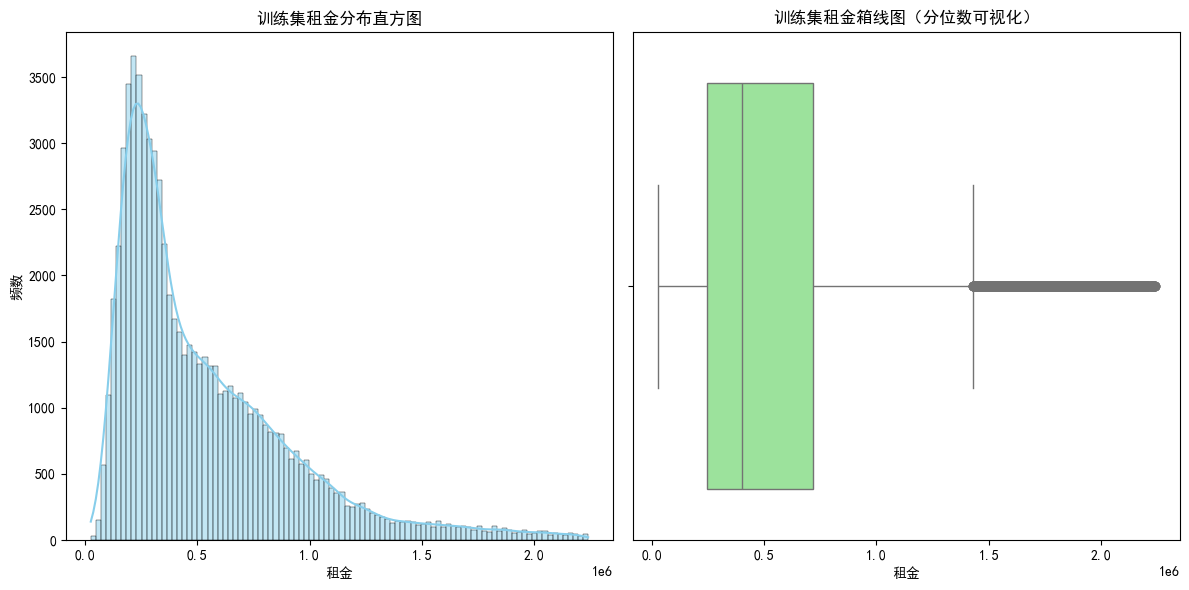

count      72692.00
mean      530910.32
std       389542.31
min        27553.77
25%       244442.53
50%       400552.80
75%       718560.09
max      2238715.98
Name: Price, dtype: float64


In [32]:
plt.rcParams["font.family"] = ["SimHei"]  
plt.rcParams["axes.unicode_minus"] = False  # 解决负负号显示异常

# 1. 计算各百分位数值（0-100分位，间隔5分位）
percentiles = np.arange(0, 101, 5)  # 0,5,10,...,100分位
rent_percentiles = np.percentile(y_train_original, percentiles)

# 转换为DataFrame，方便查看
percentile_df = pd.DataFrame({
    "百分位（%）": percentiles,
    "租金数值": rent_percentiles.round(2)  # 保留2位小数
})

print("===== 训练集租金各百分位分布 =====")
display(percentile_df)

# 2. 可视化百分位分布（箱线图+直方图结合）
plt.figure(figsize=(12, 6))

# 左侧：直方图展示整体分布
plt.subplot(1, 2, 1)
sns.histplot(y_train_original, kde=True, color='skyblue')
plt.title('训练集租金分布直方图')
plt.xlabel('租金')
plt.ylabel('频数')

# 右侧：箱线图展示分位数分布
plt.subplot(1, 2, 2)
sns.boxplot(x=y_train_original, color='lightgreen')
plt.title('训练集租金箱线图（分位数可视化）')
plt.xlabel('租金')

plt.tight_layout()
plt.show()

# 3. 重点关注关键分位（如25%、50%、75%、90%、95%、99%）
key_percentiles = [0, 25, 50, 75, 90, 95, 99, 100]
key_rent_percentiles = np.percentile(y_train_original, key_percentiles)
key_df = pd.DataFrame({
    "关键百分位（%）": key_percentiles,
    "租金数值": key_rent_percentiles.round(2)
})
print(y_train_original.describe().round(2))

## step4 模型调参

In [33]:
# 合并特征与目标变量
train_combined = pd.concat([X_train_rent, y_train_rent], axis=1)

# 计算目标变量与各特征的相关系数（皮尔逊）
corr_with_target = train_combined.corr()[y_train_rent.name].drop(y_train_rent.name).sort_values(ascending=False)

# 转换为DataFrame展示
corr_df = pd.DataFrame({
    '特征名称': corr_with_target.index,
    '与目标变量的相关系数': corr_with_target.values
})

print("目标变量与各特征的相关性（显示所有行）：")
pd.set_option('display.max_rows', None)
display(corr_df)

目标变量与各特征的相关性（显示所有行）：


,特征名称,与目标变量的相关系数
0,板块_区县内相对编码,0.361107
1,面积,0.342766
2,lon,0.311524
3,district_68.0,0.302611
4,city_4,0.301174
5,停车费用,0.266389
6,供热费,0.227030
7,租赁_整租,0.213179
8,district_81.0,0.206834
9,建筑结构_分级,0.193945
